In [1]:
import os, sys
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

import numpy as np
import pandas as pd
from sklearn.decomposition import PCA
# from sklearn.manifold import TSNE SLOW!!
from MulticoreTSNE import MulticoreTSNE as TSNE
import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
from mpl_toolkits.mplot3d import Axes3D
import sys
import random
import os
import pickle
import torch
from proemb.models.multitask import ProSEMT
from Bio import SeqIO, SCOP
from proemb.alphabets import Uniprot21

from proemb.models.lstm import SkipLSTM
from torch.nn.utils.rnn import pad_sequence
import tqdm as tqdm

%matplotlib inline
random.seed(42)
np.random.seed(42)

In [70]:
base = "/scratch/ii1g17/protein-embeddings" if 'SLURM_JOB_NAME' in os.environ else "../../data/scratch"
selected = "LM+IFACE"

In [72]:
model_names = {"LM": "multitask/v100-6gpu/3096239",
              "LM+CMAP": "multitask/1080-12gpus/3379022",
              "LM+SURF": "multitask/1080-12gpus/3908159",
              "LM+IFACE": "multitask/1080-12gpus/4800106",
              "LM+CMAP+SURF": "multitask/1080-12gpus/4747032",
              "LM+CMAP+SURF+IFACE": "multitask/1080-12gpus/4834946"}

model_path = f"{base}/saved_models/{model_names[selected]}/iter_{150000}_checkpoint.pt"
encoder = SkipLSTM(21, 100, 512, 3)
model = ProSEMT(encoder, None, None, None, None)
# only using the encoder weights
checkpoint = torch.load(model_path, map_location=torch.device('cpu'))
model.load_state_dict(checkpoint['model'], strict=False)

_IncompatibleKeys(missing_keys=[], unexpected_keys=['interface_predictor.linear.main.0.weight', 'interface_predictor.linear.main.0.bias', 'interface_predictor.linear.main.3.weight', 'interface_predictor.linear.main.3.bias', 'interface_predictor.linear_distance.main.0.weight', 'interface_predictor.linear_distance.main.0.bias', 'interface_predictor.linear_distance.main.3.weight', 'interface_predictor.linear_distance.main.3.bias', 'interface_predictor.linear_delta_sasa.main.0.weight', 'interface_predictor.linear_delta_sasa.main.0.bias', 'interface_predictor.linear_delta_sasa.main.3.weight', 'interface_predictor.linear_delta_sasa.main.3.bias'])

In [62]:
def get_seq_avg_representation(seqs, model, apply_plm_head=True):
    
    alphabet = Uniprot21()
        
    seqs = [torch.LongTensor(alphabet.encode(str.encode(seq.upper()))) for seq in seqs]
    seqs = sorted(seqs, key=lambda x: x.size()[0], reverse=True)
    seqs_lengths = torch.FloatTensor([len(seq) for seq in seqs])
    
    seqs = pad_sequence(seqs, batch_first=True, padding_value=20)

    embedding = model(seqs, seqs_lengths, apply_proj=False)
    if apply_plm_head:
        embedding = model.skipLSTM.cloze(embedding)
              
    return torch.mean(embedding, 1)

In [58]:
scope_fasta = SeqIO.parse(f"{base}/data/SCOPe/astral-scopedom-seqres-gd-sel-gs-bib-95-2.06.fa", "fasta")
scope_dict = SeqIO.to_dict(scope_fasta)
scop_db = SCOP.Scop(dir_path=f"{base}/data/SCOPe", version="2.06")

In [4]:
scop_folds = []
for k,v in scope_dict.items():
    if scop_db.getDomainBySid(k) is None:
        scop_folds.append("UNKNOWN")
        continue
    hierarchy = scop_db.getDomainBySid(k).toClaRecord().hierarchy
    fold_name = scop_db.getNodeBySunid(int(hierarchy["cf"])).description
    scop_folds.append(fold_name)
    
df = pd.DataFrame({'ids': [k for k,v in scope_dict.items()],
                   'seqs': [str(v.seq) for k,v in scope_dict.items()],
                   'scop_classes': [v.description.split(" ")[1].split(".")[0] for k,v in scope_dict.items()],
                   'scop_folds': scop_folds})

In [74]:
embeddings = []
batch = 32
apply_plm_head=False
for seqs in tqdm.tqdm(np.array_split(df['seqs'], int(len(df)/batch))):
    batch_res = get_seq_avg_representation(list(seqs), model, apply_plm_head=apply_plm_head).detach().numpy()
    for res in batch_res:
        embeddings.append(res) 
np.save(f'{base}/data/SCOPe/embeddings/scope-2.06-averaged-embeddings-using-model={selected}.npy', embeddings)

100%|██████████| 875/875 [13:51<00:00,  1.05it/s]  


In [43]:
selected

'LM+CMAP'

In [75]:
embeddings = np.load(f'{base}/data/SCOPe/embeddings/scope-2.06-averaged-embeddings-using-model={selected}.npy')
tsne = TSNE(n_jobs=-1, n_components=2, verbose=1, perplexity=600, random_state=42)
components = tsne.fit_transform(np.array(embeddings))
np.save(f'{base}/data/SCOPe/embeddings/scope-2.06-averaged-embeddings-using-model={selected}-TSNE.npy', embeddings)

Performing t-SNE using 16 cores.
Using no_dims = 2, perplexity = 600.000000, and theta = 0.500000
Computing input similarities...
Building tree...
 - point 2801 of 28010
 - point 5602 of 28010
 - point 8403 of 28010
 - point 11204 of 28010
 - point 14005 of 28010
 - point 16806 of 28010
 - point 19607 of 28010
 - point 22408 of 28010
 - point 25209 of 28010
 - point 28010 of 28010
Done in 322.00 seconds (sparsity = 0.106221)!
Learning embedding...
Iteration 51: error is 72.167679 (50 iterations in 15.00 seconds)
Iteration 101: error is 70.436537 (50 iterations in 15.00 seconds)
Iteration 151: error is 69.090771 (50 iterations in 15.00 seconds)
Iteration 201: error is 69.036459 (50 iterations in 16.00 seconds)
Iteration 251: error is 69.020027 (50 iterations in 15.00 seconds)
Iteration 301: error is 1.876955 (50 iterations in 14.00 seconds)
Iteration 351: error is 1.605002 (50 iterations in 14.00 seconds)
Iteration 401: error is 1.472633 (50 iterations in 14.00 seconds)
Iteration 451: e

In [40]:
components = np.load(f'{base}/data/SCOPe/embeddings/scope-2.06-averaged-embeddings-using-model={selected}-TSNE.npy')

/home/ii1g17/.conda/envs/prose/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/home/ii1g17/.conda/envs/prose/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/home/ii1g17/.conda/envs/prose/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  

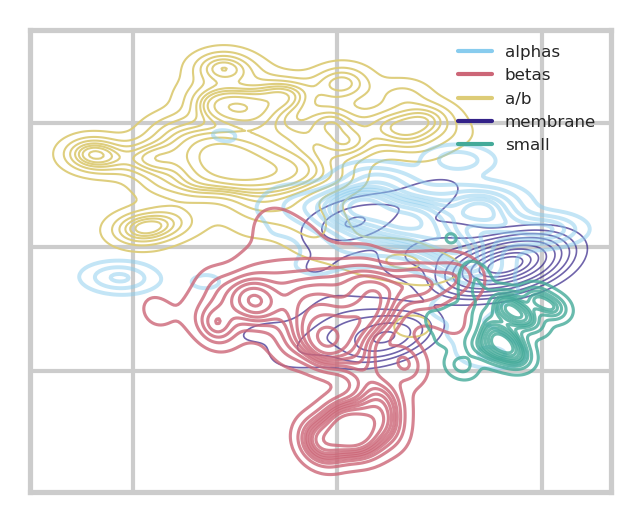

In [76]:
"""
code adapted from:
https://github.com/churchlab/UniRep-analysis/blob/a0a02ece044a7f44c6045ea446eda3f71275ac71/figures/figure2/fig2c.ipynb"""

fig = plt.figure(figsize=(2.5,2), dpi=300)
ax = fig.add_subplot(111)
import palettable as pal
palette = pal.cartocolors.qualitative.Safe_10.mpl_colors
sns.set(style="whitegrid", font="Arial", palette=palette)

label_order = [ "a","b","c","f","g"]

colors = {
    "a":sns.color_palette()[0],
    "b":sns.color_palette()[1],
    "c":sns.color_palette()[2],
    "d":sns.color_palette()[8],
    "e":sns.color_palette()[5],
    "f":sns.color_palette()[4],
    "g":sns.color_palette()[6],
}
pretty_names = {
    "a":"alphas",
    "b":"betas",
    "c":"a/b",
    "d":"a+b",
    "e":"Multi domain",
    "f":"membrane",
    "g":"small",
}
lw = [.4,.45,.5,.55,.6,.7,1,1.5,2,3,5]
colorpal = [colors[o] for o in label_order]

for i,cl in enumerate(label_order):
    mask = df['scop_classes'] == cl
    x = components[mask,0]
    y = components[mask,1]
    if cl == "a":
        sns.kdeplot(x,y,shade=False, label=cl, 
                colors=[colorpal[i]], cmap=None, linewidths=.95, alpha=.5, zorder=100)
    elif cl == "b" or cl == "g":
        sns.kdeplot(x,y,shade=False, label=cl, 
                colors=[colorpal[i]], cmap=None, linewidths=.75, alpha=.8, zorder=100)
    elif cl == "c":
        sns.kdeplot(x,y,shade=False, label=cl, 
                colors=[colorpal[i]], cmap=None, linewidths=.5, alpha=0.95, zorder=50)
    else:
        sns.kdeplot(x,y,shade=False, label=cl, 
                colors=[colorpal[i]], cmap=None, linewidths=.4, alpha=.7)

custom_lines = [ Line2D([0], [0], color=colors[o], lw=1) for o in label_order ]
ax.legend(custom_lines, [pretty_names[o] for o in label_order], loc="upper right", fontsize=4, frameon=False).set(zorder=200)
ax.axes.xaxis.set_ticklabels([])
ax.axes.yaxis.set_ticklabels([])

plt.savefig(f'scope_2.06_full_tsne_model={selected}.pdf', bbox_inches='tight', dpi=300)

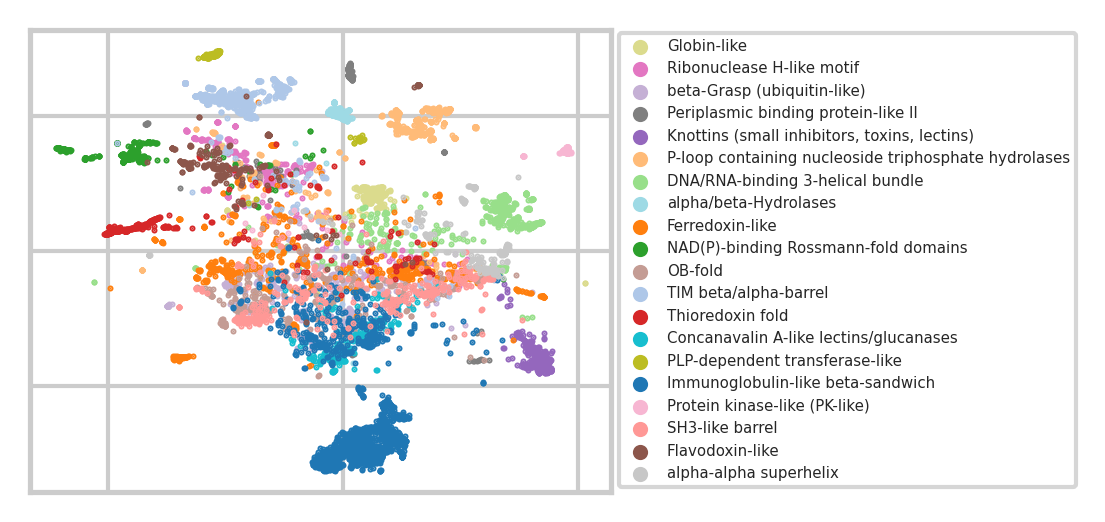

In [77]:
import matplotlib.pyplot as plt
import numpy as np
sns.set(style="whitegrid", font="Arial")

# Create a colormap that generates distinct colors for each class
cmap = plt.get_cmap('tab20', lut=20)  # You can choose a different colormap and adjust 'lut' as needed

fig = plt.figure(figsize=(2.5, 2), dpi=300)
ax = fig.add_subplot(111)

top_folds = list(df['scop_folds'].value_counts().keys())[:20]

# Create a dictionary to map classes to distinct colors
class_color_mapping = {}
for i, fl in enumerate(top_folds):
    class_color_mapping[fl] = cmap(i % 20)  # Modulus ensures distinct colors, adjust '20' if needed

for i, fl in enumerate(set(list(df['scop_folds']))):

    if fl not in top_folds:
        continue

    mask = df['scop_folds'] == fl

    x = components[mask, 0]
    y = components[mask, 1]
    plt.scatter(x, y, s=0.2, alpha=1, label=fl, c=[class_color_mapping[fl]])  # Assign colors based on the mapping

ax.axes.xaxis.set_ticklabels([])
ax.axes.yaxis.set_ticklabels([])
legend = plt.legend( prop={'size': 3.6}, bbox_to_anchor=(1, 1.01), scatterpoints=1)

for handle in legend.legendHandles:
    handle.set_sizes([7.0])

plt.savefig(f'scope-2.06-tsne-level=fold-top={len(top_folds)}-model={selected}.pdf', bbox_inches='tight', dpi=300)


In [ ]:
a = dict(df['scop_folds'].value_counts())
len(dict(df['scop_folds'].value_counts()))

1218

In [31]:
len([k for k,v in a.items() if v >=20])

236

In [4]:
import numpy as np
a = np.array([0,0,0,1,1,1,0])
b = np.array([1,0,0,1,0,0,0])

mask = a * (1 - b)
print(mask)

[0 0 0 0 1 1 0]
